In [1]:
# | tags: [parameters]
subject = "101"

In [2]:
#| tags: [parameters]
# Injected Parameters
subject = 101


In [3]:
import os
import mne
from pathlib import Path
import autoreject
from autoreject import AutoReject
import numpy as np
import matplotlib.pyplot as plt

from spectral.utils import print_date_time, read_parameters, config_project
from spectral.epochs import create_epochs, get_reject_log
from spectral.viz import plot_epochs

mne.viz.set_browser_backend("matplotlib")
# mne.viz.set_browser_backend("qt")
mne.set_config("MNE_BROWSER_THEME", "light")
# matplotlib.use("Agg")

config = read_parameters()
my_paths = config_project(subject)

project_path = my_paths["project_path"]
raw_preproc_path = my_paths["raw_preproc_path"]
epochs_preproc_path = my_paths["epochs_preproc_path"]

print(epochs_preproc_path)
Path(epochs_preproc_path).mkdir(parents=True, exist_ok=True)

figures_path = my_paths["figures_path"]

print_date_time()

Using matplotlib as 2D backend.


/Users/daniel/PhD/Projects/psd-path/analysis/data/epochs/sub-101/
2024-03-25 01:23:49


# Get bad channels


Opening raw data file /Users/daniel/PhD/Projects/psd-path/analysis/data/raw/sub-101//sub-101_filtered_zap_eeg.fif...


    Range : 0 ... 150000 =      0.000 ...   300.000 secs


Ready.


Reading 0 ... 150000  =      0.000 ...   300.000 secs...


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,260 points
Good channels,"244 EEG, 1 ECG"
Bad channels,"VREF, E133, E217, E9, E132, E238, E145, E91, E174, E229, E251, E216, E256"
EOG channels,Not available
ECG channels,ECG
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,100.00 Hz


Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


Using data from preloaded Raw for 85 events and 2501 original time points ...


0 bad epochs dropped


No projector specified for this dataset. Please consider the method self.add_proj.


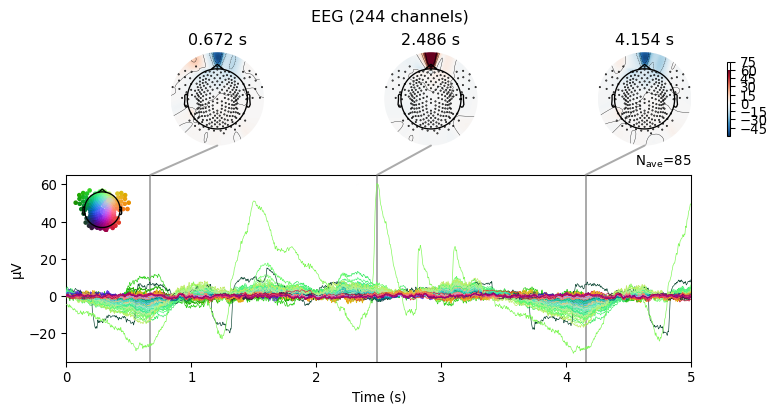

Effective window size : 4.096 (s)


Averaging across epochs...


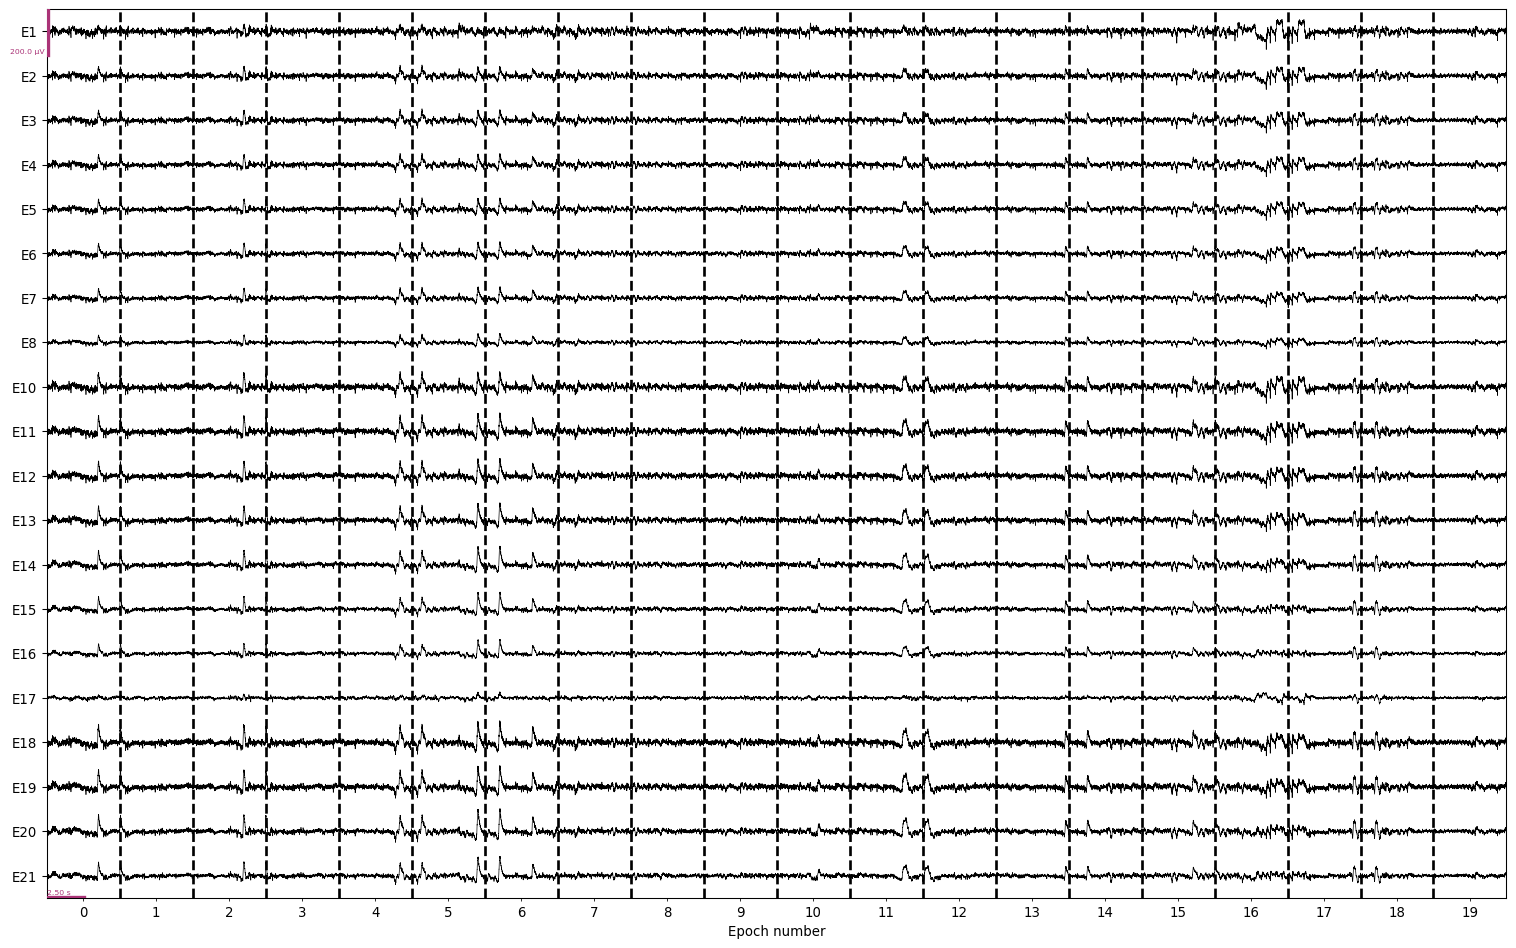

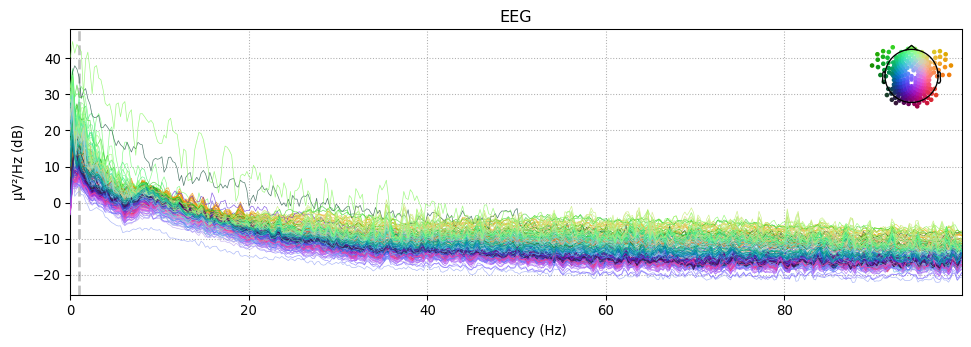

In [4]:
clean_raw = mne.io.read_raw_fif(
    f"{raw_preproc_path}/sub-{subject}_filtered_zap_eeg.fif", preload=True
)
display(clean_raw.info)
# clean_raw_downsampled = clean_raw.copy().resample(250, npad="auto")
epochs = create_epochs(clean_raw, overlap=1.5)
plot_epochs(
    epochs,
    figures_path=figures_path,
    subject=subject,
    stage="epochs",
    n_epochs=20,
    n_channels=20,
)

fitting finished


Dropped 20 epochs: 0, 5, 6, 16, 17, 30, 36, 37, 38, 39, 40, 48, 62, 72, 73, 75, 76, 82, 83, 84


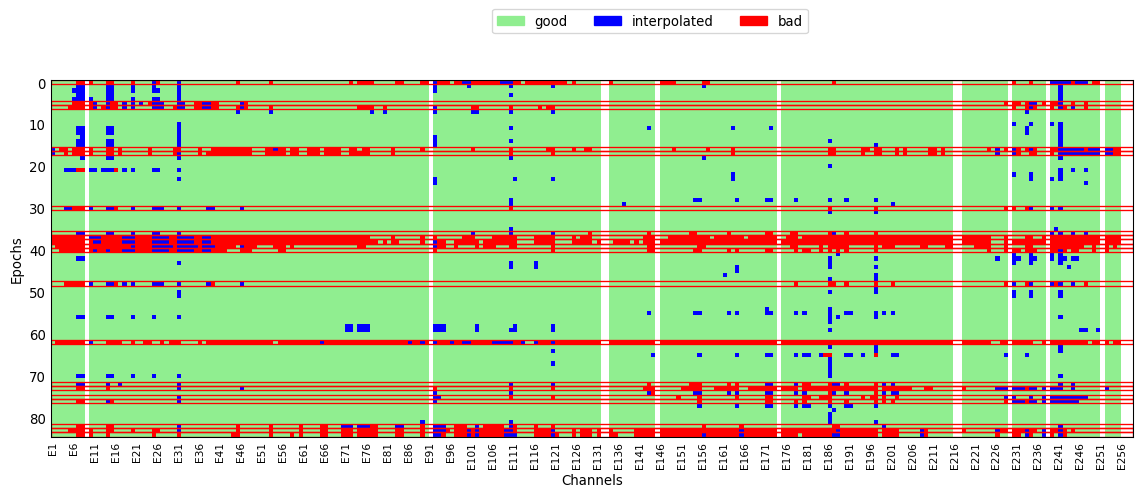

In [5]:
# depending of the resampling - different number of epochs are rejected
reject_log = get_reject_log(epochs, resample=125, consensus=[0.10])
reject_plot = reject_log.plot("vertical")

## Show bad epochs


No projector specified for this dataset. Please consider the method self.add_proj.


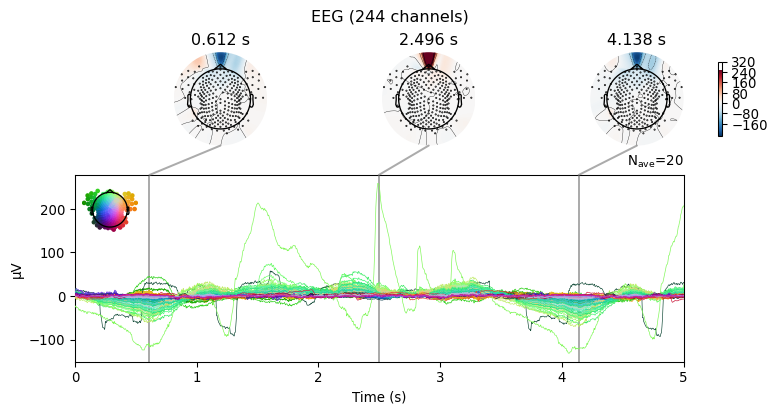

Effective window size : 4.096 (s)


Averaging across epochs...


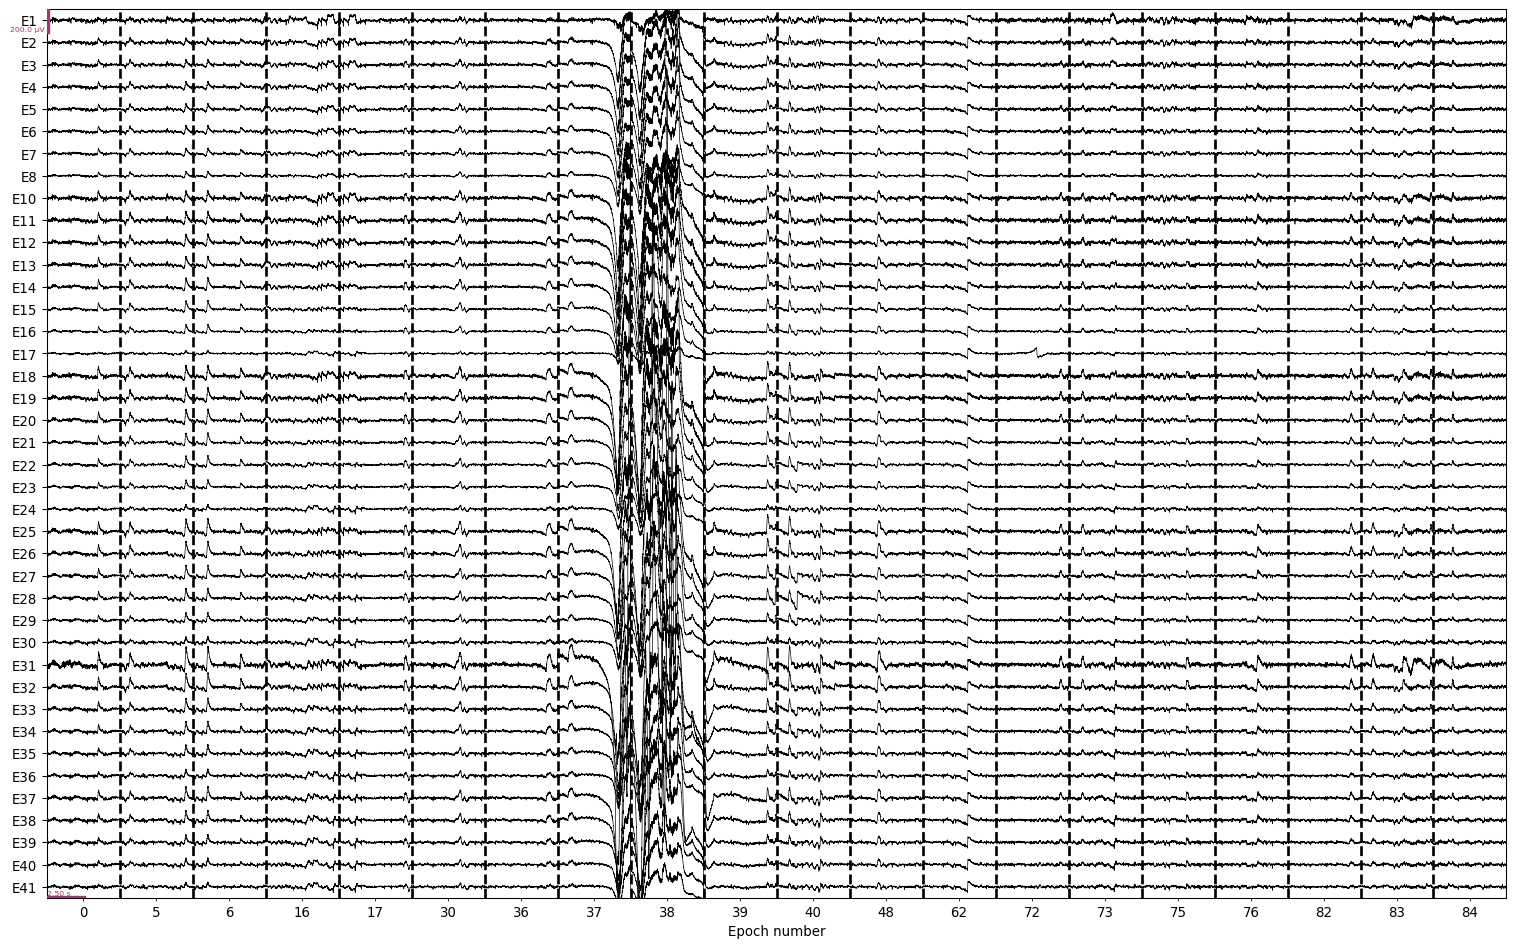

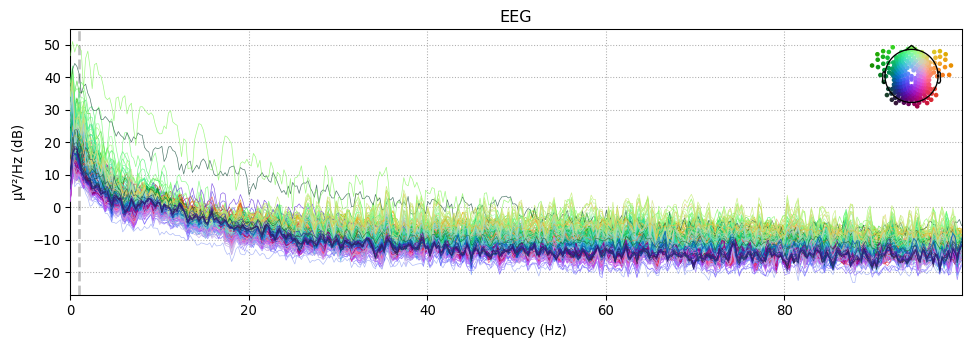

In [6]:
plot_epochs(
    epochs[reject_log.bad_epochs],
    figures_path=figures_path,
    subject=subject,
    stage="autoreject_bad_epochs",
    n_epochs=len(epochs[reject_log.bad_epochs]),
    n_channels=40,
)

# Show good epochs after removal


No projector specified for this dataset. Please consider the method self.add_proj.


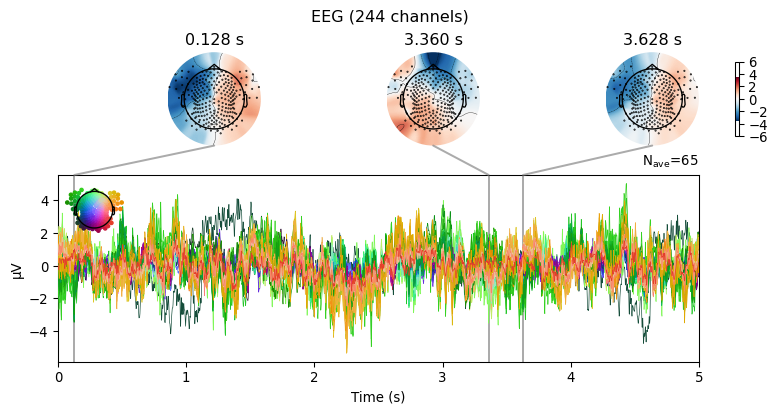

Effective window size : 4.096 (s)


Averaging across epochs...


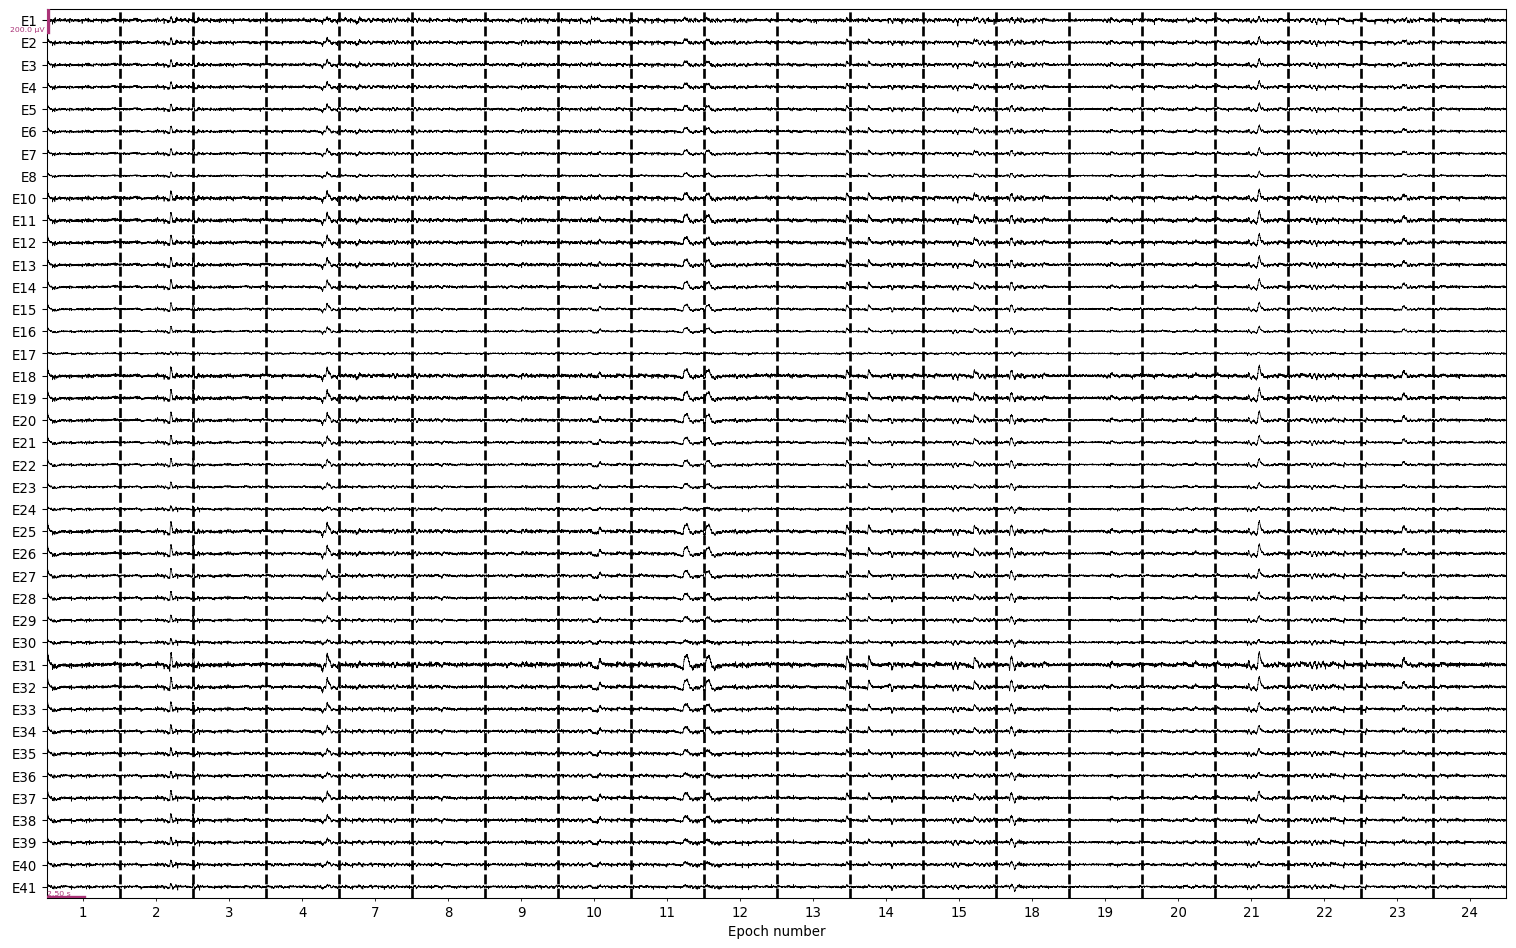

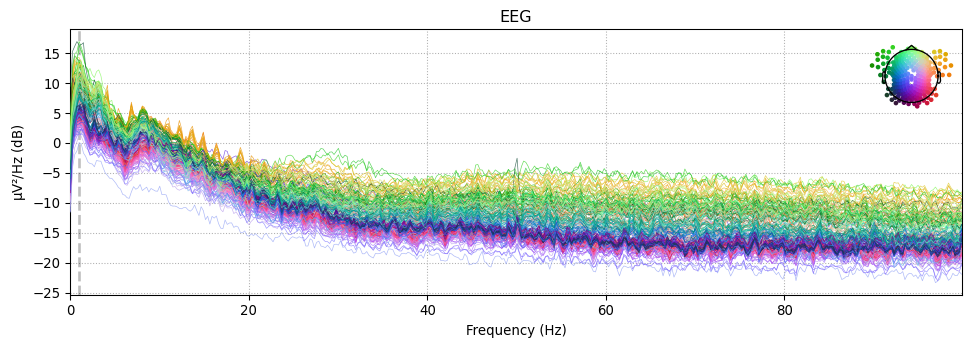

In [7]:
plot_epochs(
    epochs[~reject_log.bad_epochs],
    figures_path=figures_path,
    subject=subject,
    stage="autoreject_good_epochs",
    n_epochs=20,
    n_channels=40,
)

In [8]:
epochs[~reject_log.bad_epochs].save(
    f"{epochs_preproc_path}/sub-{subject}_drop_bad-epo.fif", overwrite=True
)

Overwriting existing file.


Overwriting existing file.


In [9]:
print(f"Sub{subject} -  removed {sum(reject_log.bad_epochs)} epochs")
print(f"Sub{subject} -  retained {len(epochs[~reject_log.bad_epochs])} epochs")

print_date_time()

Sub101 -  removed 20 epochs
Sub101 -  retained 65 epochs
2024-03-25 01:24:33
